# Faster RCNN

## Goals:
- Training/Inference available to user
- Inference:
    - ...
- Training:
    - User submitted parameters:
        - k: number of anchors
        - pretrained network (ZF/VGG16/user submitted)
        - n: spatial window size
        - window map output dimension (ZF:256-d/VGG16:512d)
        - scale/aspect ratios of anchors
        - IoU limits (upper and lower) for flagging anchors
        - loss functions: one for Lcls, one for Lreg, one for the combination of the two
        - optimizers: one for RPN branch and one for CLS branch
        - mini-batch size of randomly sampled anchors (default 256)
        - ratio of positive to negative anchors in mini-batch (default 1:1)
        - new layer initilization functions (default Gauss 0mean, 0.01std)
        - weight initialization for the base (pretrained) model

## Components


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Data:
- PASCAL VOC 2007:
    - trained on VOC 2007 trainval
    - test on testset

In [8]:
import tensorflow_datasets as tfds

In [12]:
test_ds, train_ds, valid_ds = tfds.load("voc").values()

In [ ]:
#FeaturesDict({
#    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
#    'image/filename': Text(shape=(), dtype=tf.string),
#    'labels': Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=20)),
#    'labels_no_difficult': Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=20)),
#    'objects': Sequence({
#        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
#        'is_difficult': tf.bool,
#        'is_truncated': tf.bool,
#        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
#        'pose': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
#    }),
#})

### Shared body:
- The first network to process the images and produce features that are then fed into the RPN and Classifier head
- Pretrained on ImageNet
- Archecture of network will determine the receptive field size given the n x n sliding window over the feature layer's outputs

In [35]:
import matplotlib.pyplot as plt

In [38]:
pretrained = tf.keras.applications.vgg16.VGG16(
    include_top = False, weights='imagenet'
)
pretrained.trainable = False

Image shape: (480, 389, 3)
Pretrained output shape: (1, 15, 12, 512)
Image shape: (375, 500, 3)
Pretrained output shape: (1, 11, 15, 512)
Image shape: (375, 500, 3)
Pretrained output shape: (1, 11, 15, 512)
Image shape: (500, 375, 3)
Pretrained output shape: (1, 15, 11, 512)


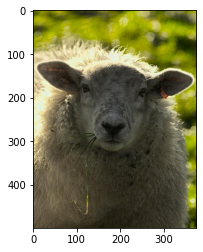

In [43]:
for sample in train_ds.take(4):
    image = sample['image']
    print("Image shape:", image.shape)
    features = pretrained(image[tf.newaxis, ...])
    print("Pretrained output shape:", features.shape)
plt.imshow(image)

In [70]:
# Approximate method of determining receptive field size:
#   - appears that ratio is 3:100 for receptive:base pixels
test_image_1 = tf.zeros((1, 100, 100, 3))
test_image_2 = tf.zeros((1, 1000, 1000, 3))

out_1 = pretrained(test_image_1)
out_2 = pretrained(test_image_2)

print(out_1.shape)
print(out_2.shape)

basetoreceptive = 3/100.

(1, 3, 3, 512)
(1, 31, 31, 512)


### RPN

In [71]:
class RPN(keras.Model):
    def __init__(self, n=3, k=9):
        super(RPN, self).__init__()

        self.k = k
        self.n = n

        self.windowmap = layers.Conv2D(512, (n,n), activation="relu",
                                      name="windowmap")
        self.reglayer = layers.Conv2D(4*k, (1,1),
                                     name="reglayer")
        self.clslayer = layers.Conv2D(2*k, (1,1), activation="sigmoid",
                                     name="clslayer")
        
    def clsloss(self, p, p_tar):
        loss = keras.losses.BinaryCrossentropy(p, p_tar)
        return loss

    def call(self, input_images):
        x = self.windowmap(input_images)

        reg = self.reglayer(x)
        regshape = tf.shape(reg)
        reg = tf.reshape(reg, (regshape[1], regshape[2], 9, 4))

        cls = self.clslayer(x)
        clsshape = tf.shape(cls)
        cls = tf.reshape(cls, (clsshape[1], clsshape[2], 9, 2))

        return [reg, cls]

In [72]:
rpn = RPN()
reg, cls = rpn(features)
print(reg.shape)
print(cls.shape)

(13, 9, 9, 4)
(13, 9, 9, 2)


### RoI Pooling

In [ ]:
# Inputs:
#   - RoI BBoxes
#   - Features
#
# Outputs:
#   - RoI Feature Vectors


class RoIPool(keras.Model):
    def __init__(self):
        super(RoIPool, self).__init__()

        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(32)
        self.fc2 = layers.Dense(64)

    def pool_roi(self, roi):
        # roi :: (None, None, 512)
        # pooled_roi :: (7, 7, 512)
        roishape = tf.shape(roi)

        input = roishape
        ksize = [roishape[0] // 7, roishape[1] // 7]
        strides = ksize
        padding = "SAME"

        pooled_roi = tf.nn.max_pool2d(input=input,
                                      ksize=ksize,
                                      strides=strides,
                                      padding=padding)
        return pooled_roi

    def call(self, inputs):
        # inputs -- [image_features, reg]
        # image_features :: (1, None, None, 512)
        # bboxes :: (~2000, 4)
        image_features, bbox = inputs
        bbox_crop = lambda x: tf.image.crop_to_bounding_box(image_features,
                                                            x[0], x[1], x[2], x[3])
        rois = tf.map_fn(bbox_crop, bboxes) # :: (~2000, None, None, 512)
        pooled_rois = tf.map_fn(self.pool, rois) # :: (~2000, 7, 7, 512)

        x = self.flatten(pooled_rois) # :: (~2000, 7 * 7 * 512)
        x = self.fc1(x)
        x = self.fc2(x)
        return x # :: (~2000, 64)

### Classifier

In [ ]:
inputs = keras.Input(shape=(64))
output = layers.Dense(1000, activation="softmax")(inputs)
# Note: could also include an additional bbox regressor
#   as is the case in Fast RCNN
headclassifier = keras.Model(inputs=inputs, outputs=output)

### Full Model

In [74]:
class FasterRCNN(keras.Model):
    def __init__(self):
        super(FasterRCNN, self).__init__()
        self.base = pretrained
        self.rpn = RPN()
        self.roipool = RoIPool()
        self.headclassifier = headclassifier

    def call(self, input_image):
        # input_image :: (1, None, None, 3)

        # features :: (1, None, None, 512)
        features = self.base(input_image)

        # reg :: (None, None, 9, 4)
        # cls :: (None, None, 9, 2)
        reg, cls = self.rpn(features)

        # Perform parameterization ops on reg
        # bboxes = f(reg)

        # bboxes :: (~2000, 4)
        # roifeaturevectors:: (~2000, 64)
        roifeaturevectors = self.roipool([features, bboxes])

        # class_preds :: (~2000, 1000)
        class_preds = self.headclassifier(roifeaturevectors)

        return [class_preds, bboxes]

In [ ]:
    def __init__(self, anchor_scales=[128, 256, 512], 
                       anchor_aspectratios=[1., 2., .5]):
        super(RoIPool, self).__init__()
        self.k = len(anchor_scales) * len(anchor_aspectratios)
        self.anchor_scales = tf.floor(tf.constant(anchor_scales) * basetoreceptive)
        self.anchor_aspectratios = tf.constant(anchor_aspectratios)

### Region Proposal Network (RPN)
- input: image of any size
- output: set of rectangular object proposals, each w/ an "objectness" score
- black box: 
    - n x n spatial window slides across feature map output
        - ie. n x n convolutional layer
        - w/ n=3, ZF/VGG receptive field size is 171/228 pixels
    - window maps to lower-dimensional feature (256-d/512-d w/ ReLU)
    - feed feature into 2 sibling FCNs
        - Box-regression layer (reg)
        - Box-classification layer (cls)
        - ie. 1 x 1 convolutional layers
    - at each sliding-window location, predict multiple proposals given number of anchors k
        - therefore, reg layer has 4k outputs encoding coordinates
            - parameterize w.r.t k reference boxes
        - therefore, cls layer has 2k outputs estimating probability of object or not object
        - each anchor has specified scale and aspect ratio
            - use 3 scales, 3 aspect ratios for k = 9 anchors
        - translation-invariant anchors:
            - regress bounding boxes w/ ref to anchor boxes
    - loss function:
        - for training, assign binary class label (obj or not) to each anchor
            - Positive:
                - anchor/anchors w/ highest IoU overlap w/ ground-truth box (rare case)
                - OR
                - anchor that has IoU overlap higher than 0.7 with any ground-truth box (most common case)
            - single ground-truth box may assign positive labels to multiple anchors
            - Negative:
                - non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes
            - Neither:
                - then anchors don't contribute to training
        - Loss Function defined in paper
            - Lcls is log loss over two classes
            - Lreg is robust loss function (ie. smooth L1)
            - regression loss activated only for positive anchors
            - normalization by scale factor (optional)
        - bbox parameterization:
            - define w/ log and distance from corners of bbox and size of box
            - essentially, regression from anchor box to nearby ground-truth box
            - translation-invariant
    - Training RPNs
        - stochastic gradient descent
        - each mini-batch arises from single image containing many positive and negative anchors
        - to prevent bias towards the more common negative anchors, randomly sample 256 anchors in image w/ up to 1:1 ratio
            - if fewer than 128 positive samples, pad mini-batch w/ negative ones
        - randomly initialize all new layers by drawing weights form zero-mean Gauss distrib. w/ std of 0.01
            - all other layers (ie. shared conv layers) are initialized by pretraining model for ImageNet classification (ie. fine-tune ZF, VGG, etc.)
        - lr = 0.001 for 60k mini-batches
        - lr = 0.0001 for next 20k mini-batches
        - momentum = 0.9
        - weight decay = 0.0005

## Training: 4-Step Alternating Training
1. fine-tune pre-trained ImageNet model for RPN
2. train separate detection network by Fast R-CNN using generated proposals from step-1 (also a pre-trained ImageNet model)
3. use detector network to initialize RPN training, but fix the shared conv layers and only fine-tune the layers unique to RPN (now two networks share conv layers)
4. keeping shared layers fixed, fine-tune unique layers of Fast R-CNN


## Training: Approximate joint training
- RPN and Fast RCNN merged into one network
- in each SGD iteration, forward pass generates region proposals which are then passed to the Fast RCNN classifier and are treated as static givens (ie. no backprop path)
- backprop is the usual, where shared layers receive backprop signlas from both RPN loss and Fast RCNN loss, combined
- Note: soln is easy but ignored the derivative wrt the proposal boxes' coordinates that are also network responses, so is approximate
- should produce close results to method 1, but should be faster

## Training: Non-approximate joint training
- since the RoI Pooling Layer in FastRCNN accepts the conv features AND the predicted bounding boxes as inputs, grads should theoretically be valid wrt the box coordinates (ie. TF GradientTape should be able to handle the gradient across the bounding box outputs)
- would mean we need RoI pooling layer that is differentiable wrt the box coordinates (according to author, nontrivial problem)

## Implementation Details:
- re-scale images such that shorter side is s = 600 pixels
- for anchors, use 3 scales w/ box areas of 128^2, 256^2, 512^2 and 3 aspect ratios of 1:1, 1:2, 2:1
    - note that the bbox prediction is allowed to be larger than the underlying anchor in the receptive field
- for anchor boxes that cross image boundaries:
    - during training, ignore so they don't contribute to loss
        - for 1000 x 600 images, roughly 20000 anchors where 6000 are not cross-boundary
    - during testing, clip the proposals that are cross-boundary and return
- to reduce redundancy in overlapping proposals, adopt non-max suppression on proposals based on cls scores.
    - fix IoU thresh for NMS at 0.7, leaving ultimately about 2000 proposal regions per image
    - after NMS, use top-N ranked proposal regions for detection
    - Note: can be more lax during training and more strict during testing

## Experiments:
- Paper performed experiments on the PASCAL VOC detection benchmark
- as well as the MS COCO object detection dataset

### Fast R-CNN object detection network

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
pretrained = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', classes=1000
)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
pretrained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
class RPN(keras.Model):
    def __init__(self, pretrained, n=3, k=9):
        super(RPN, self).__init__()
        self.pretrained = pretrained

        self.windowmap = keras.Conv2D(512, (n,n), activation="relu")
        self.reglayer = keras.Conv2D(4*k, (1,1))
        self.clslayer = keras.Conv2D(2*k, (1,1), activation="sigmoid")

    def call(self, input_images):
        x = self.pretrained(input_images)
        x = self.windowmap(input_images)
        reg = self.reglayer(x)
        cls = self.clslayer(x)

        

In [ ]:
class Classifier(keras.Model):
    def __init__(self, pretrained):
        super(Classifier, self).__init__()
        self.pretrained = pretrained
    
    def call(self, input_images):
        pass

In [ ]:
class FasterRCNN(keras.Model):
    def __init__(self, RPN, Classifier):
        super(FasterRCNN, self).__init__()
        self.RPN = RPN
        self.Classifier = Classifier

    def compile(self, optimizer):
        super(FasterRCNN, self).compile()
        self.optimizer = optimizer

    def call(self, input_images):
        rpn_out = self.RPN(input_images)
        classifier_out = self.Classifier(input_images)
        return tf.concat([rpn_out, classifier_out])

    def train_step(self, input_images):
        with tf.GradientTape() as tape:
            out = self(input_images)
            loss = loss_fn(out, tar)
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer = self.optimizer.apply_gradients(
            zip(grads, self.trainable_weights)
        )
        return {"loss": loss}